In [222]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import csv

In [223]:
#Define your path to directory with raw particle data
path = "017" 

In [224]:
# for loop that combines all .xls files within path directory. Creates new variable "all_data" as .csv 
# and saves within path directory as "total_particles"
all_data = pd.DataFrame()
for f in glob.glob(path+'\*.xls'): #you may need to change \ -> / if on mac
    df = pd.read_csv(f,sep='\s+') #you may need to change \ -> / if on mac
    df['fileName'] = f[4:11]
    df['ParticleNumber'] = range(len(df)+1)[1:] # add particle number for matching up plankton
    
    all_data = all_data.append(df,ignore_index=True) 
    

all_data.to_csv(path+'/total_particles.csv')

In [225]:
# Read new total_particle.csv and define variable "area" 
file= path+'/total_particles.csv'
df = pd.read_csv(file,header=0)
area=df['Area']
TP = len(area)
print(TP)

# transform surface area to equivalent spherical diameter (ESD)
ESD = (2*(area/np.pi)**.5) 


41


In [226]:
# define bins (how many, width, and center). Code in this cell modified from Colleen Durkin. 

bins = []
for x in np.arange(2,10,.5):  #This was 1.5,10,.5
    bin = 2**x
    bins.append(bin)

bin_mids = []
for y in np.arange(0,len(bins)-1):
    mid = bins[y] + (bins[y+1]-bins[y])/2
    bin_mids.append(mid)

bin_width = []
for z in np.arange(0,len(bins)-1):
    width = (bins[z+1]-bins[z])
    bin_width.append(width)

In [227]:
# Use numpy histgram to sort particle counts into size class bins. This sorted data is then normalized by bin width. 

histogram=np.histogram(ESD,bins=bins,range=None, normed=False, weights=None, density=None) 
n=((histogram[0]*30.376)/bin_width)*10 #normalized multiplied counts by (30.376) to represent particles/1mL


In [228]:
# get rid of bins with no data

bin_mids_array=np.asarray(bin_mids) # change bin_mids from tuple to array so can be indexed
ii=np.where(n>0) # index to remove zero data
bin_mids_nonzero=bin_mids_array[ii] # only bins with data
n_nozero=n[ii] # no zero values

In [229]:
# PSD function will be used in max.min to calculate differences in estimated power equation from real data

def PSD (var, bin_mid, normalized): #var is in format of [#,#], normilized = my n
    normalized_n = normalized#[normalized>0]
    bin_center = bin_mids_nonzero # figure this line out
    Y = (10**var[0])*bin_mids_nonzero**var[1]
    difference = np.sum((np.log(Y)- np.log(n_nozero))**2)
    return difference 

In [230]:
# optimize the power equation fit using PSD function. Output is variables A and B in equation y = A(x)^B

maxmin=scipy.optimize.minimize(PSD, [1, -3], args= (bin_mids, n)) # then use these to plot y= over hist with estimates of [1,-3]
intercept = np.round(maxmin['x'][0],2)
slope = np.round(maxmin['x'][1],2)
print(intercept, slope)

3.86 -1.51


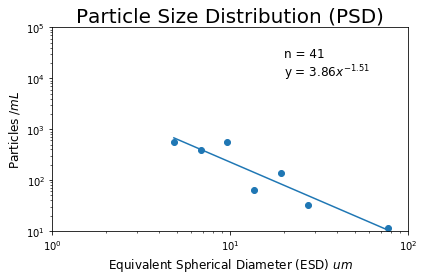

In [231]:
plt.figure()
plt.scatter(bin_mids_nonzero, n_nozero)
plt.plot(bin_mids_nonzero,(10**maxmin['x'][0])*bin_mids_nonzero**(maxmin['x'][1])) #this is where you add in variable x from optimize.min result 
plt.xlabel('Equivalent Spherical Diameter (ESD) $um$', fontsize=12 )
plt.ylabel('Particles /$mL$', fontsize=12)
plt.title('Particle Size Distribution (PSD)', fontsize=20)
plt.text(20,10000,'n = %s \ny = %s$x^{%s}$ '%(TP, intercept, slope), fontsize = 12)
plt.yscale('log')
plt.xscale('log')
plt.axis([1,100,10,100000])
plt.tight_layout()
plt.savefig(path+'PSDplot')
plt.show()

In [232]:
# add slope and intercept for power eqution, and total particle counts to main data file 

df['Intercept'] = maxmin['x'][0]
df['Slope'] = maxmin['x'][1]
df['Total']= TP
df['Images'] = len(glob.glob(path+'\*.xls'))
df['ESD'] = ESD
df['AverageArea'] = sum(df['Area'])/df['Total'][1]
df['TotalArea'] = sum(df['Area'])
df['TotalESD'] = sum(df['ESD'])
df['AverageESD'] = sum(df['ESD'])/df['Total'][1]
cols = list(df.columns.values)
print(cols)
df = df[['fileName', 'Area', 'ESD','fileName', 'ParticleNumber', 'Intercept', 'Slope', 'Total', 'Images', 'TotalArea', 'AverageArea', 'AverageESD', 'TotalESD']]


['Unnamed: 0', 'Area', 'Mean', 'Min', 'Max', 'fileName', 'ParticleNumber', 'Intercept', 'Slope', 'Total', 'Images', 'ESD', 'AverageArea', 'TotalArea', 'TotalESD', 'AverageESD']


In [233]:
df.head()


,fileName,Area,ESD,fileName,ParticleNumber,Intercept,Slope,Total,Images,TotalArea,AverageArea,AverageESD,TotalESD
0,017-001,92.670,10.862371,017-001,1,3.860816,-1.507588,41,18,8192.416,199.815024,8.101025,332.142008
1,017-001,322.782,20.272612,017-001,2,3.860816,-1.507588,41,18,8192.416,199.815024,8.101025,332.142008
2,017-002,83.299,10.298523,017-002,1,3.860816,-1.507588,41,18,8192.416,199.815024,8.101025,332.142008
3,017-002,4.165,2.302834,017-002,2,3.860816,-1.507588,41,18,8192.416,199.815024,8.101025,332.142008
4,017-002,193.669,15.703090,017-002,3,3.860816,-1.507588,41,18,8192.416,199.815024,8.101025,332.142008


In [234]:
savefile = "%s_%s.csv" % (path, 'totalParticles')

df.to_csv(savefile) #add name conv
